<a href="https://colab.research.google.com/github/Beatrixwmh/phase-4-project/blob/main/ph_4_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project Submission <br/>
####Name: Beatrix Wong
####Student pace: Flex
####Scheduled project review date/time: 7/8/2023, 12 pm
####Instructor name: Morgan Jones


## Introduction
In this notebook, I will build a natural language processing model that classifies tweets according to the sentiment expressed.
## Data preprocessing
First, I will import the relevant data with which I can train and evaluate the model and do some explorative data analysis. The data I will be using is from data.world, consisting of instances of tweets along with labels of their sentiments. More information about the data can be found [here](https://data.world/crowdflower/brands-and-product-emotions/workspace/file?filename=judge-1377884607_tweet_product_company.csv).

In [1]:
#import data
import pandas as pd
df= pd.read_csv('sentiments.csv', encoding = 'iso-8859-1')

In [2]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
df.shape

(9093, 3)

For ease of analaysis, I will simplify column names.

In [4]:
#rename columns
df.columns= ['text', 'product','sentiment']

In [5]:
#check class counts
df['sentiment'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

There seems to be a strong class imbalance where the vast majority of the data belongs to the nautral class. <br/>
Moreover, since the 'I can't tell' rows are ambiguous and therefore provide no useful information, and consist only of a small portion of the data, I will drop them.



In [6]:
#dropping ambiguous columns
df.drop(df[df['sentiment']== "I can't tell"].index, inplace= True)

In [7]:
#re-examine dataframe
df.head()

,text,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [8]:
#inspect null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8937 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       8936 non-null   object
 1   product    3282 non-null   object
 2   sentiment  8937 non-null   object
dtypes: object(3)
memory usage: 279.3+ KB


There seems to be a lot of null values in the product column, however, since my goal is to identify the sentiment of a given tweet regardless of the product, the columns useful to my analyse would be 'text' and 'sentiment' only.

In [9]:
#look at relevant null rows
df[df[['text','sentiment']].isna().any(axis=1)]

,text,product,sentiment
6,NaN,NaN,No emotion toward brand or product


In [10]:
#since it is just one row, I will drop it
df.drop(6, inplace=True)

Next, I will seperate the target and feature columns and do a train-test-split.


In [11]:
#train test split
from sklearn.model_selection import train_test_split, cross_val_score
X= df['text']
y= df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state= 15)

In [12]:
#visually inspect a few rows
pd.set_option('display.max_colwidth', None)
X_train.sample(5)

8699                                        We interrupt your regularly scheduled #sxsw geek programming with big news {link}  #google #circles
6893    RT @mention We're excited to be at #sxsw and giddy to announce that Music WithMe for Android is now available in Android Market. {link}
693                                                                           Designing iPad Interfaces - New Navigation Schemas.\n#SXSW #UXDes
893                                 HootSuite Mobile for #SXSW ~ Updates for iPhone, BlackBerry &amp; Android: Shared by PaulÛ_ {link} #shared
8068                               #sxsw hotspots by Klout score? Score! Cluster, a @mention @mention  mashup from @mention and @mention {link}
Name: text, dtype: object

Text(0.5, 1.0, 'Class Distributions')

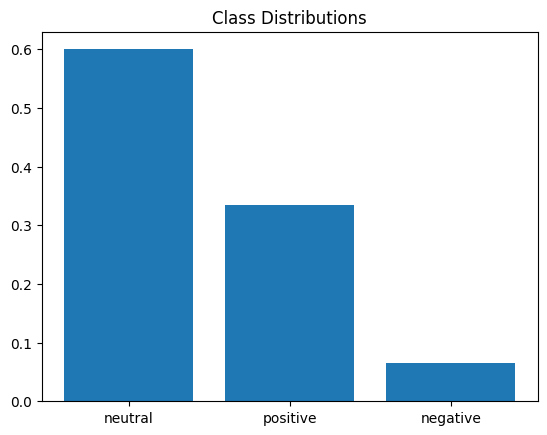

In [15]:
#inspect class proportions in the training set
import matplotlib.pyplot as plt
class_dist= y_train.value_counts()/ y_train.shape[0]
plt.bar(['neutral','positive','negative'], class_dist)
plt.title('Class Distributions')

Looks like the neutral class consists of 60% of the whole training set.

## vectorization and modelling
Next, I will explore different ways to tokenize and vectorize the data to find a set that produces the best results. Moreover, I will visualize the distributions to guage how different preprocessing stategies would affect the features in my model.

In [16]:
#lowercasing train set
X_train_lower= X_train.str.lower()
X_train.head()

1732                   I am not #SXSW worthy since I don't know what UX is. RT @mention \nSo, @mention product on the iPhone. Period. The UX is...
7816                                                      thanks, Bryan RT @mention Official #SXSW App Û÷SXSW GOÛª {link} #android #iphone #ipad
1248                                Great way to prep! RT @mention Download 20+ FREE tracks from #SXSW Music Sampler available on @mention  {link}
7856                                                Dispatches from the #iPad 2 front lines {link} #aspengrove #aspengrove #austin #line #sxsw #tx
1037    .@mention Rec: Give the Bad Apple a job in a mtg, such as taking notes. Make mtg voluntary =&gt; willing participants. #gamestorming #sxsw
Name: text, dtype: object

In [17]:
#tokenize text without punctuation
from nltk.tokenize import RegexpTokenizer
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
import string
import re
import numpy as np

basic_token_pattern = r"(?u)\b\w\w+\b"

tokenizer = RegexpTokenizer(basic_token_pattern)
X_train_token= X_train_lower.apply(lambda x: tokenizer.tokenize(str(x)))
X_train_token[:5]

1732                     [am, not, sxsw, worthy, since, don, know, what, ux, is, rt, mention, so, mention, product, on, the, iphone, period, the, ux, is]
7816                                                         [thanks, bryan, rt, mention, official, sxsw, app, sxsw, go, ûª, link, android, iphone, ipad]
1248                            [great, way, to, prep, rt, mention, download, 20, free, tracks, from, sxsw, music, sampler, available, on, mention, link]
7856                                                    [dispatches, from, the, ipad, front, lines, link, aspengrove, aspengrove, austin, line, sxsw, tx]
1037    [mention, rec, give, the, bad, apple, job, in, mtg, such, as, taking, notes, make, mtg, voluntary, gt, willing, participants, gamestorming, sxsw]
Name: text, dtype: object

Now that I have a tokenized version of the text, I will plot the distrubutions of the top 10 most common words from each class.

In [18]:
#visualize distributions
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)


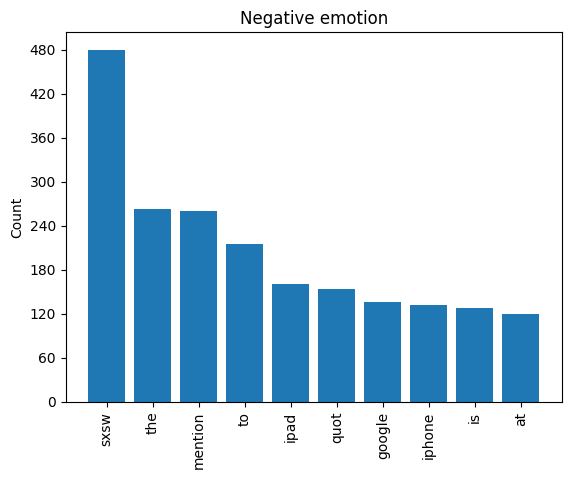

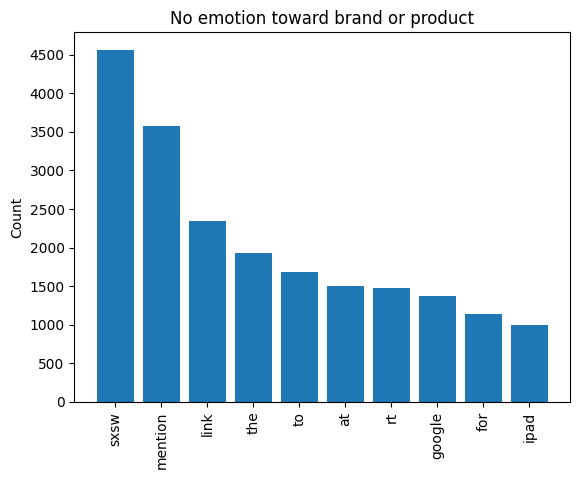

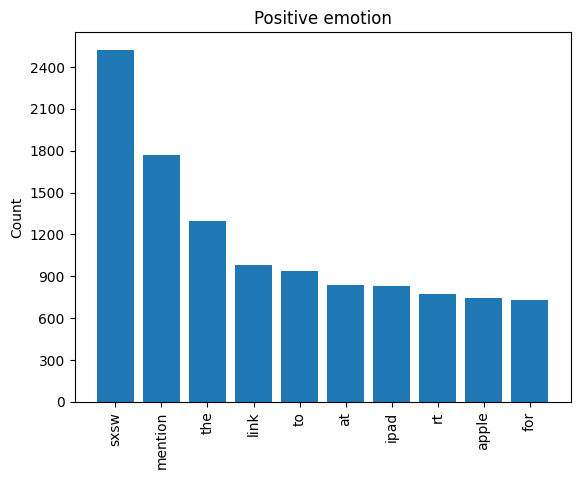

In [19]:
#create bar graphs for each sentiment
for emotion in set(y_train.values):
  index= y_train[y_train== emotion].index
  x= X_train_token.loc[index]
  freqdist= FreqDist(x.explode())
  visualize_top_10(freqdist, emotion)


Looks like a lot of stop words and neutral nouns like 'sxsw' and 'ipad', moreover, most of the most common words are shared among all three classes. <br/>
I will first build a simple baseline model using multinomial naive bayes based on the vectorized data of these tokens, setting the number of features to 100 and using the default token pattern.

In [20]:
# Baseline model with multinomialNB
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=100
tfidf = TfidfVectorizer(max_features=100)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train)

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out()).head()

,about,all,amp,an,and,android,app,apple,apps,are,...,today,up,via,was,we,what,will,with,you,your
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.376021,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.431821,0.393278,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.364427,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [21]:
# Import relevant class and function for modelling and evaluation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv.mean()

0.6147183956701101

The accuracy is quite low, but still better than random guessing. Next, I will stem the words and also remove stopwords to see if more informative and unique words would surface. <br/>
I will first visualize the distribution, then pass it into our baseline model to see if it yields better results.

In [22]:
#create function that stems and tokenizes text
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language="english")

def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [stemmer.stem(token) for token in tokens]
X_train_token_stemmed = X_train_token.apply(lambda x: [stemmer.stem(token) for token in x])

In [23]:
#removing stopwords
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords


stopwords_list = stopwords.words('english')
stem_and_sw_token= X_train_token_stemmed.apply(lambda x: [w for w in x if w not in stopwords_list])

In [24]:
stem_and_sw_token[:5]

1732                              [sxsw, worthi, sinc, know, ux, rt, mention, mention, product, iphon, period, ux]
7816                      [thank, bryan, rt, mention, offici, sxsw, app, sxsw, go, ûª, link, android, iphon, ipad]
1248        [great, way, prep, rt, mention, download, 20, free, track, sxsw, music, sampler, avail, mention, link]
7856                             [dispatch, ipad, front, line, link, aspengrov, aspengrov, austin, line, sxsw, tx]
1037    [mention, rec, give, bad, appl, job, mtg, take, note, make, mtg, voluntari, gt, particip, gamestorm, sxsw]
Name: text, dtype: object

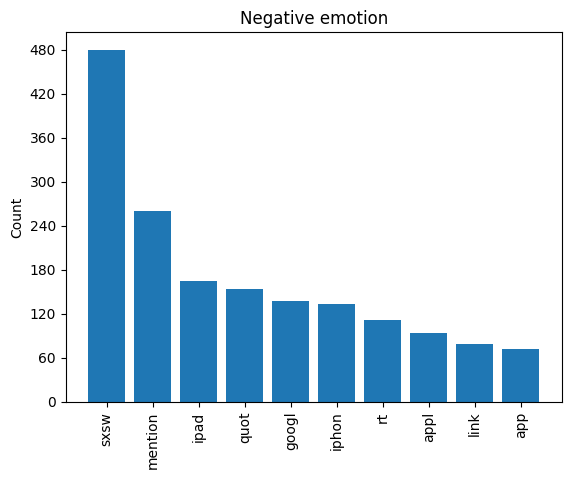

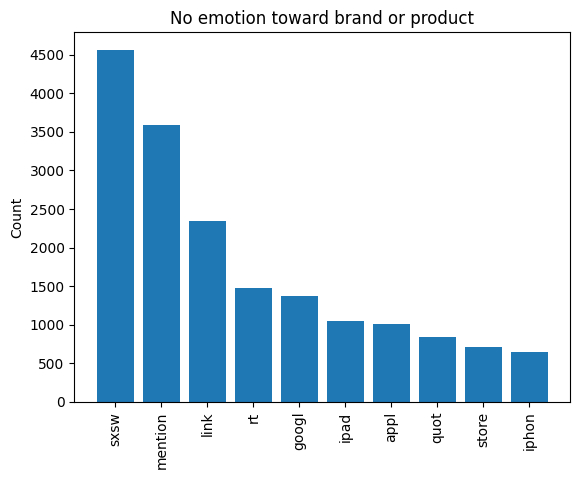

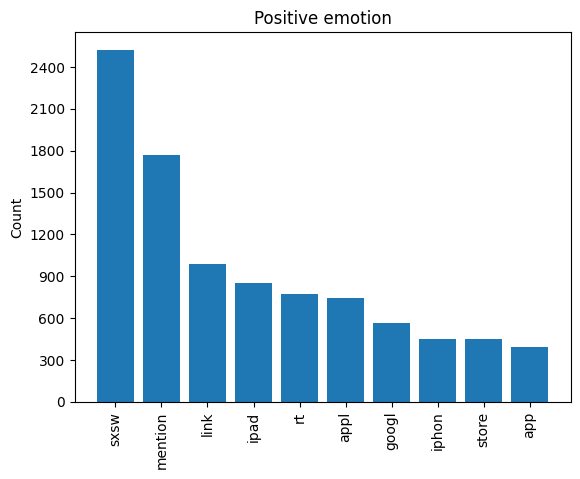

In [25]:
#distribution of tokens without stopwords and after stemming
for emotion in set(y_train.values):
  index= y_train[y_train== emotion].index
  x= stem_and_sw_token.loc[index]
  freqdist= FreqDist(x.explode())
  visualize_top_10(freqdist, emotion)


They still more or less share the same words, which are mainly product and event names, moreover, they share the two most common words, in a similar vein to removing stopwords, I will try removing the words they share in common to see if it improves model performance.

In [26]:
def remove_shared_tokens(x,y):
  '''
  removes words that are universally common across three classes with the same rank of frequency.
  Returns the tokens without shared words along with a list of words removed.
  '''
  ls= []
  common=[]
  for i,emotion in enumerate(set(y.values)):
    index= y[y==emotion].index
    text= x.loc[index]
    top_100= FreqDist(text.explode()).most_common(10)
    ls.append(top_100)
  for i in range(0,10):
    if ls[0][i][0] == ls[1][i][0] == ls[2][i][0]:
      common.append(ls[0][i][0])
  return x.apply(lambda x: [w for w in x if w not in common]), common




In [27]:
common_and_stopwords_removed, common_words= remove_shared_tokens(stem_and_sw_token, y_train)
common_words

['sxsw', 'mention']

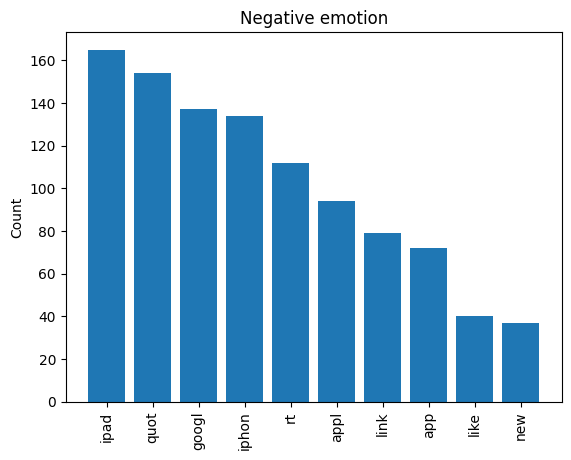

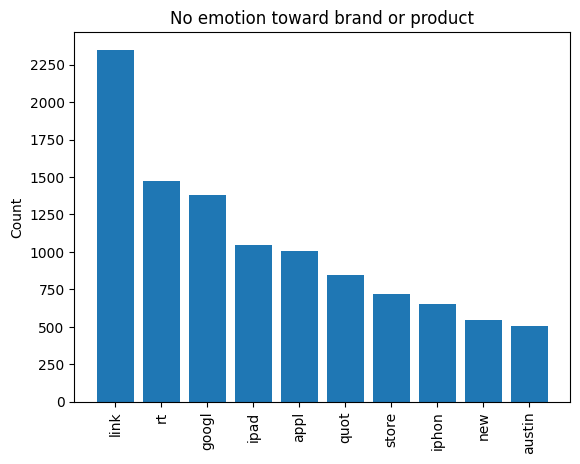

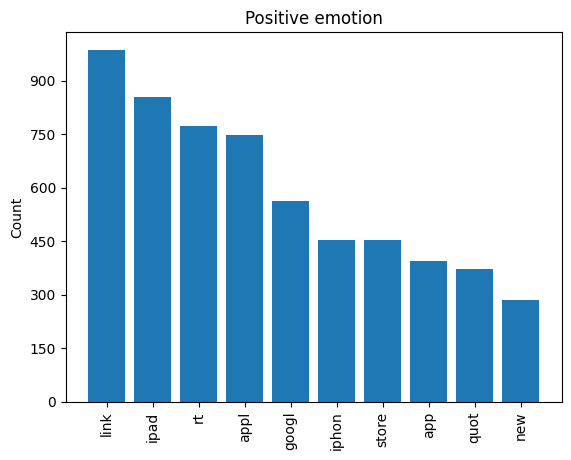

In [28]:
#distribution after removing shared common words
for emotion in set(y_train.values):
  index= y_train[y_train== emotion].index
  x= common_and_stopwords_removed.loc[index]
  freqdist= FreqDist(x.explode())
  visualize_top_10(freqdist, emotion)


The distribution has changed, but it is unclear if it helped. I will cross validate two sets, one with stopwords removed, and one with both stopwords and common words removed respectively. Moreover, I will increase the max_features parameter to capture more information.

In [29]:
# no stopwords and stemmed
# Instantiate a vectorizer with max_features=500
# (we are using the default token pattern)
tfidf = TfidfVectorizer(max_features=500,
                        stop_words= stopwords_list,
                        tokenizer= stem_and_tokenize)
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Fit the vectorizer on X_train and transform it
sw_and_stem_vec_train = tfidf.fit_transform(X_train)

# model cross val
cross_val_score(baseline_model,sw_and_stem_vec_train, y_train).mean()

0.6589229105394255

In [30]:
# no stopwords + stemmed + common words removed
# Instantiate a vectorizer with max_features=
# (we are using the default token pattern)
tfidf2 = TfidfVectorizer(max_features=500,
                        stop_words= stopwords_list+ common_words,
                         tokenizer= stem_and_tokenize)

# Fit the vectorizer on X_train["text"] and transform it
new_vec_train = tfidf2.fit_transform(X_train)
new_vec_train_df= pd.DataFrame.sparse.from_spmatrix(new_vec_train,columns= tfidf2.get_feature_names_out(), index= X_train.index)

# model cross val
cross_val_score(baseline_model, new_vec_train, y_train).mean()

0.659482155353394

It seems that removing common words slightly improved the model, I will keep it.

In [31]:
#set vec_train as the second set of vectorized tokens
vec_train = new_vec_train
#create dataframe
vec_train_df= pd.DataFrame.sparse.from_spmatrix(vec_train, columns= tfidf2.get_feature_names_out(), index= X_train.index)

## Feature Engineering
In this section, I will try to add various features to the dataframe to see if it would improve the performance of the model.

First, I will examine bigrams and visualize the distributions of the top 5 most common pairs of words in each class. <br/>
Before I do so, I will remove human names from the tokens, since mentions of celebrity names would be common, but not useful for analysing sentiment. To do so, I have imported a csv file from GitHub containing a comprehensive list of the most common first names. I will use list comprehension to remove tokens that appear in the list of names. The github repository from which I had found this csv file can be found [here](https://github.com/hadley/data-baby-names/blob/master/baby-names.csv).

In [32]:
#a list of common first names
names= [x.lower() for x in pd.read_csv('https://raw.githubusercontent.com/hadley/data-baby-names/master/baby-names.csv')['name']]
#define function that removes names from a list of tokens
def remove_names(tokens):
    return [x for x in tokens if x not in names]
#apply to X_train
names_removed = X_train_token.apply(remove_names)

#stemming
bigram_tokens= names_removed.apply(lambda x: [stemmer.stem(token) for token in x])
bigram_tokens[:5]

1732         [am, not, sxsw, worthi, sinc, know, what, ux, is, rt, mention, so, mention, product, on, the, iphon, period, the, ux, is]
7816                                                       [thank, rt, mention, offici, sxsw, app, sxsw, go, ûª, android, iphon, ipad]
1248                    [great, way, to, prep, rt, mention, download, 20, free, track, from, sxsw, music, sampler, avail, on, mention]
7856                                                    [dispatch, from, the, ipad, front, line, aspengrov, aspengrov, line, sxsw, tx]
1037    [mention, rec, give, the, bad, appl, in, mtg, such, as, take, note, make, mtg, voluntari, gt, will, particip, gamestorm, sxsw]
Name: text, dtype: object

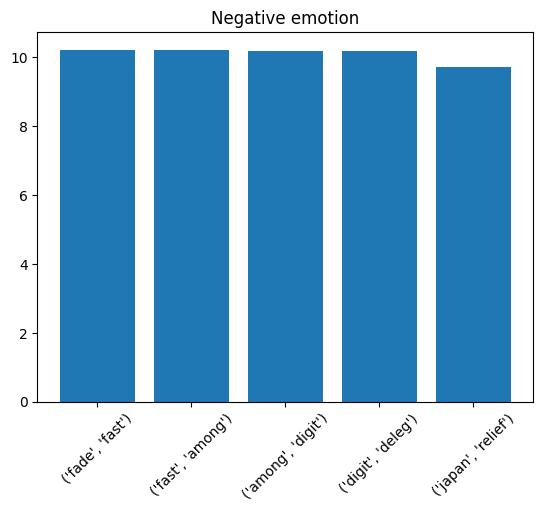

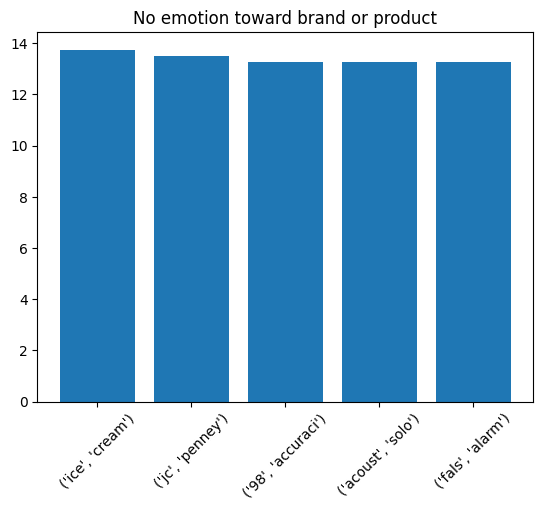

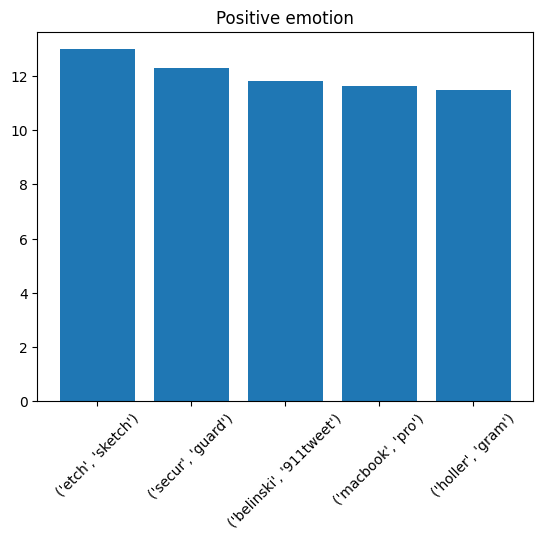

In [33]:

#visualize top 10 tuples and collect top 5 tuples from each class, stored in the list 'bigrams'
bigrams=[]
for y in set(y_train.values):
  index= y_train[y_train==y].index
  bigram_measures = nltk.collocations.BigramAssocMeasures()
  pmi_finder = BigramCollocationFinder.from_words(bigram_tokens.loc[index].explode())
  pmi_finder.apply_freq_filter(5)
  pmi_scored = pmi_finder.score_ngrams(bigram_measures.pmi)
  result=pmi_scored[:5]
  bigrams.append([x[0] for x in result[:10]])
  fig,ax = plt.subplots()
  values= [x[1] for x in result]
  ax.bar(range(len(values)),values)
  ax.set_xticks(range(len(values)))
  ax.set_xticklabels([str(x[0]) for x in result], rotation= 45)
  ax.set_title(y)
  plt.show()

Unlike singular tokens, there seems to be no overlap in bigrams between the classes, I might be able to use this as additional information.

In [34]:
#reshape bigrams list to turn into dataframe
bigrams=[tuple(x) for x in np.array(bigrams).reshape(15,2)]
bigrams

[('fade', 'fast'),
 ('fast', 'among'),
 ('among', 'digit'),
 ('digit', 'deleg'),
 ('japan', 'relief'),
 ('ice', 'cream'),
 ('jc', 'penney'),
 ('98', 'accuraci'),
 ('acoust', 'solo'),
 ('fals', 'alarm'),
 ('etch', 'sketch'),
 ('secur', 'guard'),
 ('belinski', '911tweet'),
 ('macbook', 'pro'),
 ('holler', 'gram')]

In [35]:
#add 15 columns to X_train (top 5 of each class)
ls=[]
for bi in bigrams:
  ls.append([X_train_token.apply(lambda x: 1 if (bi in list(nltk.bigrams(x))) else 0 )])

In [36]:
#create dataframe for bigrams
bigram_df= pd.DataFrame(np.array(ls).reshape(15,7148).T, columns= [bi[0] for bi in bigrams], index= X_train.index)
bigram_df.columns= bigram_df.columns.astype(str)
bigram_df.head()

,fade,fast,among,digit,japan,ice,jc,98,acoust,fals,etch,secur,belinski,macbook,holler
1732,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7816,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1248,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7856,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1037,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
#combine the dataframe with vec_train
X_with_bigrams= pd.concat([vec_train_df, bigram_df], axis=1)
X_with_bigrams.head()

,00,03,10,11,12,15,1st,20,2011,30,...,ice,jc,98,acoust,fals,etch,secur,belinski,macbook,holler
1732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.367211,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
#check cross validated accuracy with bigrams
cross_val_score(baseline_model, X_with_bigrams, y_train).mean()

0.6601816517981669

It seemed to help a little. Next, I will look at puntuation to minimize information loss from tokenization. Namely, I will add a column that represents the number of exclaimation pounts in each tweet.

In [39]:
def count_exc(sentence):
  '''
  takes in a sentence and returns the number of exclaimation points in that sentence
  '''
  pattern = r'!'
  sentence= sentence.translate(str.maketrans({'(':'\(',')':'\)'}))
  return len(re.findall(pattern, sentence))

In [40]:
#map function onto training set
series= X_train.map(count_exc)

In [41]:
#create dataframe
exc_df= pd.DataFrame(series)
exc_df.columns= ['! count']
exc_df.head()

,! count
1732,0
7816,0
1248,1
7856,0
1037,0


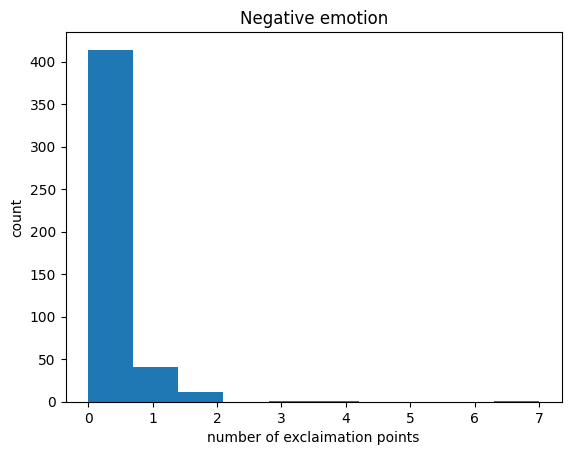

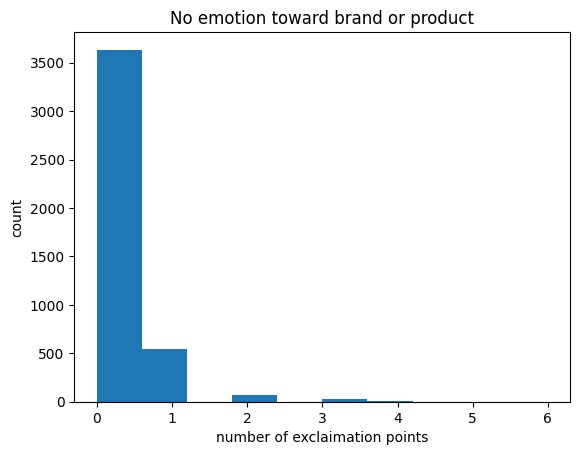

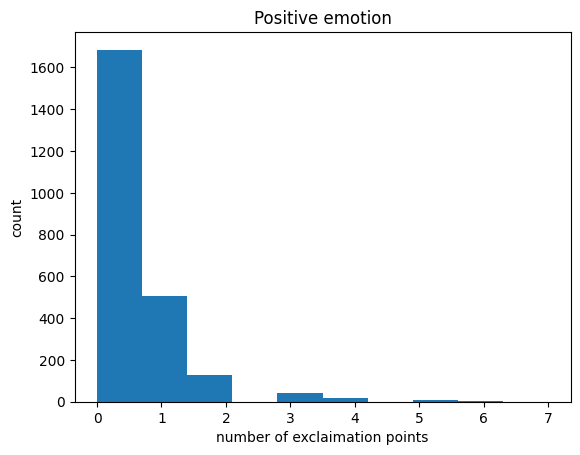

In [42]:
#visualize distributions
for y in set(y_train.values):
  index= y_train[y_train == y].index
  x= exc_df.loc[index]
  plt.hist(x)
  plt.title(y)
  plt.ylabel('count')
  plt.xlabel('number of exclaimation points')
  plt.show()

The distribution looks quite different, let's see if it helps.

In [43]:
cross_val_score(baseline_model, pd.concat([vec_train_df, exc_df], axis=1), y_train).mean()

0.6603253289747342

Another very slight improvement, I will stick with this dataframe for now.

In [44]:
#update features dataframe to include exclaimation points count
X_final = pd.concat([X_with_bigrams, exc_df], axis=1)
X_final.head()

,00,03,10,11,12,15,1st,20,2011,30,...,jc,98,acoust,fals,etch,secur,belinski,macbook,holler,! count
1732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.367211,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
7856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Visualizing features in 3 dimensios
Before evaluating the model, I will plot my features into three dimensional space for visualization.

In [45]:
#transform featurs into 3D space
from sklearn.manifold import TSNE
t_sne_object_3d = TSNE(n_components = 3,
                       perplexity = 19,
                       learning_rate = 200,
                       init = 'random',
                       random_state = 13)

transformed_data_3d = t_sne_object_3d.fit_transform(np.array(X_final))


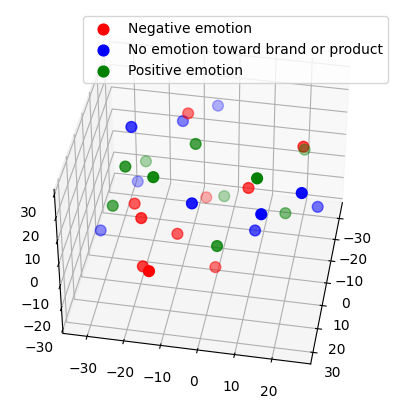

In [46]:
fig= plt.figure(figsize=(10,5))
ax= fig.add_subplot(111,projection='3d')
for i, y in enumerate(set(y_train.values)):
  color= ['r','b','g'][i]
  index= y_train[y_train== y].index
  points= pd.DataFrame(transformed_data_3d, index= y_train.index).loc[index[:10]]
  ax.scatter(points[0], points[1], points[2], c=color, s=60, label= y)
  ax.view_init(40,10)
  ax.legend()
plt.show()

Despite having added many features, the data points still look very jumbled. It seems like classifying them accurately would be a challenge. Next, I will evaluate my model fitted to these features.

## Evaluating the model
Now that I have my set of features, I will inspect the model performance more closely by looking at the confusion matrix.

In [47]:
#check confusion matrix
baseline_model.fit(X_final, y_train)

MultinomialNB()

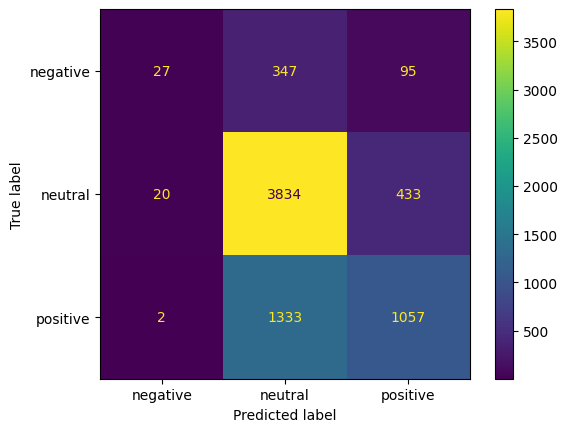

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp= ConfusionMatrixDisplay(confusion_matrix(y_train,baseline_model.predict(X_final)), display_labels= ['negative', 'neutral', 'positive'])
disp.plot()

## Dealing with class imbalance
It looks like the model just classifies most samples into the 'neutral' class. This is likely due to the class imbalance of our dataset. I will try to balance out the neutral class by oversampling the minority classes.

In [49]:
#seperate out a validation set from training set
ros_X, X_val,ros_y, y_val = train_test_split(X_final, y_train, test_size= 0.15, random_state= 13)
ros_y.value_counts()

No emotion toward brand or product    3628
Positive emotion                      2037
Negative emotion                       410
Name: sentiment, dtype: int64

In [50]:
# oversampling
from imblearn.over_sampling import RandomOverSampler
ros= RandomOverSampler()
#try fitting it to training data
X_train_ros, y_train_ros = ros.fit_resample(ros_X, ros_y)

In [51]:
#check class distribution
y_train_ros.value_counts()

Negative emotion                      3628
No emotion toward brand or product    3628
Positive emotion                      3628
Name: sentiment, dtype: int64

In [52]:
#fit model to oversampled data
oversample_nb= MultinomialNB()
oversample_nb.fit(X_train_ros, y_train_ros)

MultinomialNB()

In [53]:
#check accuracy score of validation set
from sklearn.metrics import accuracy_score
accuracy_score(oversample_nb.predict(X_val), y_val)

0.5452003727865797

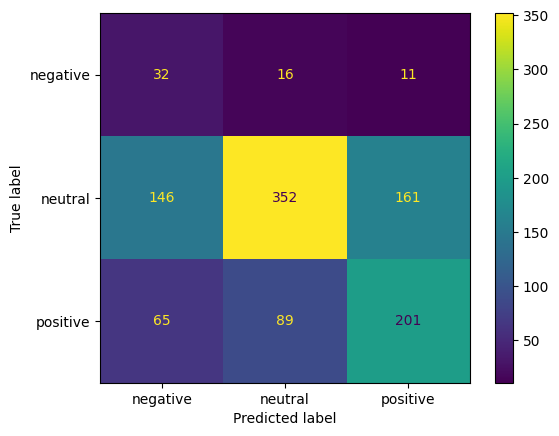

In [54]:
#check confusion matrix
disp= ConfusionMatrixDisplay(confusion_matrix(y_val,oversample_nb.predict(X_val)), display_labels= ['negative', 'neutral', 'positive'])
disp.plot()

It helped with reducing the proportion of samples being misclassified as neutral, but it is still very confused. While the accuracy is lower, it is good that the diagonals contain the majority of samples from each class. <br/>
In an attempt to improve the accuracy of my model, I will try turning it into a binary classification problem to see if it does better. I will combine the neutral and negative classes together, since there are so few negative cases.

In [55]:
#relabel targets
new_y_train= y_train.map({'Negative emotion':'not positive',
                          'No emotion toward brand or product':'not positive',
                          'Positive emotion': 'positive'})

In [56]:
new_y_train.value_counts()

not positive    4756
positive        2392
Name: sentiment, dtype: int64

In [57]:
#oversample positive cases
binary_ros = RandomOverSampler()
X_0, X_val, y_0, y_val = train_test_split(X_final, new_y_train, test_size= 0.15,random_state=13)
X_ros, y_ros= binary_ros.fit_resample(X_0,y_0)

In [58]:
y_ros.value_counts()

not positive    4038
positive        4038
Name: sentiment, dtype: int64

In [59]:
#fit the model and check accuracy with validation set
binary_mnb= MultinomialNB()
binary_mnb.fit(X_ros, y_ros)
accuracy_score(binary_mnb.predict(X_val), y_val)


0.6672879776328052

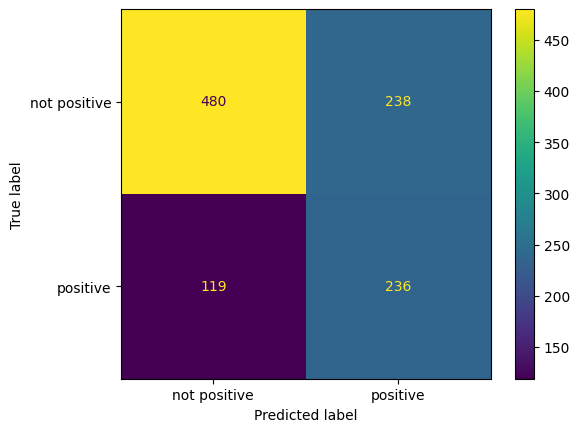

In [60]:
#look at confusion matrix
disp= ConfusionMatrixDisplay(confusion_matrix(y_val,binary_mnb.predict(X_val)), display_labels= binary_mnb.classes_)
disp.plot()

This model has a really bad precision, namely, it is bad at identifying positve cases, with equal amounts of false postives and true positives. Next, I will try three other classifiers to see if they would yield a better performance.

In [61]:
#trying other estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#obtain accuracy score from each model
for model in [('svc',SVC()), ('lr',LogisticRegression()),('rf', RandomForestClassifier())]:
  print(model[0]+': ', cross_val_score(model[1], X_final, y_train).mean())


svc:  0.6843874390130514
lr:  0.6738961668142915
rf:  0.6786513136968001


In [62]:
#looks like SVC performed the best
svc= SVC()
svc.fit(X_ros, y_ros)


SVC()

0.7287977632805219


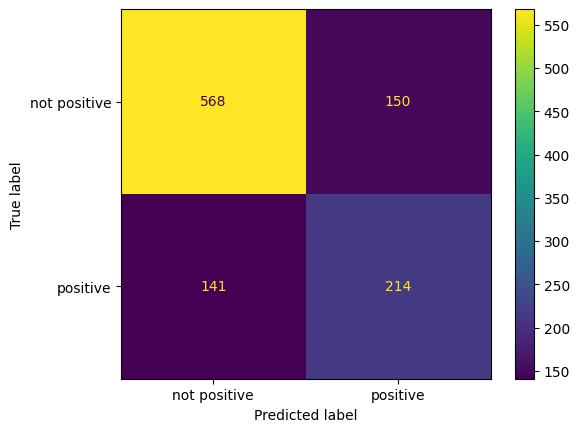

In [63]:
#check validation accuracy for SVC
disp= ConfusionMatrixDisplay(confusion_matrix(y_val,svc.predict(X_val)), display_labels= binary_mnb.classes_)
disp.plot()
print(accuracy_score(svc.predict(X_val), y_val))

This model seems to do reasonably well , definitely an improvement compared to our previous model. I will use this as my final model and evaluate its performance against the testing set.
## Final model evaluation

Seeing as the goal of this model is to the help advertisers identify positive reviews, the cost of false positives is higher than the cost of false negatives, sice misidentifying a negative tweet for a positive one would possibly mislead clients on what customers like. Therefore, I will look at the f1 score, which is a balance between precision and recall.

In [64]:
#create final model and fit to features
final_model= SVC()
ros_final= RandomOverSampler()
X_train_ros, y_train_ros= ros_final.fit_resample(X_final, new_y_train)
final_model.fit(X_train_ros, y_train_ros)
final_model.score(X_final, new_y_train)

0.8735310576385003

In [65]:
#transforming X_test
#vectorize (stopwords+ common words)
X_test_vec= tfidf2.transform(X_test)
Xt_vec_df= pd.DataFrame.sparse.from_spmatrix(X_test_vec, index= X_test.index, columns= tfidf2.get_feature_names_out())
#bigrams
Xt_tokens= X_test.apply(lambda x: [w.lower() for w in tokenizer.tokenize(str(x))])
bigrams_Xt= []
for bi in bigrams:
  bigrams_Xt.append(Xt_tokens.apply(lambda x: 1 if bi in nltk.bigrams(x) else 0))
bigrams_test= pd.DataFrame(np.array(bigrams_Xt).reshape(len(bigrams),X_test.shape[0]).T, columns= bigram_df.columns, index= X_test.index)
#! count
exc_test_df= pd.DataFrame(X_test.map(count_exc), index= X_test.index)
exc_test_df.columns= ['! count']
# concat into a unified dataframe
X_test_final= pd.concat([Xt_vec_df, bigrams_test, exc_test_df], axis=1)

In [66]:
X_test_final.columns.astype('str')
X_test_final.head()


,00,03,10,11,12,15,1st,20,2011,30,...,jc,98,acoust,fals,etch,secur,belinski,macbook,holler,! count
875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
6884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
#relabel targets
new_y_test= y_test.map({'Negative emotion':'not positive',
                          'No emotion toward brand or product':'not positive',
                          'Positive emotion': 'positive'})

In [68]:
#calculate accuracy score
accuracy_score(final_model.predict(X_test_final), new_y_test)

0.7225950782997763

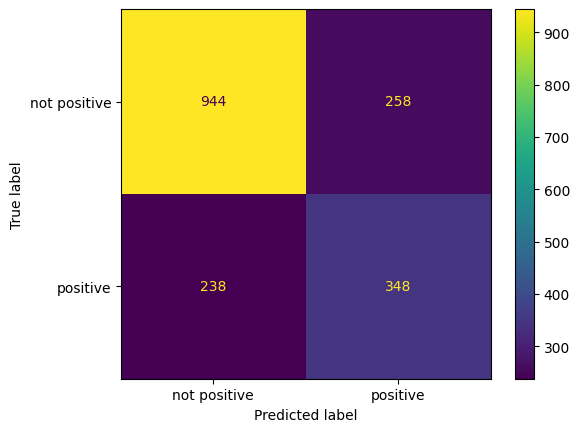

In [69]:
#look at confusion matrix
disp= ConfusionMatrixDisplay(confusion_matrix(new_y_test,final_model.predict(X_test_final)), display_labels= svc.classes_)
disp.plot()

In [70]:
#look at classification report
from sklearn.metrics import classification_report
print(classification_report(new_y_test, final_model.predict(X_test_final)))

              precision    recall  f1-score   support

not positive       0.80      0.79      0.79      1202
    positive       0.57      0.59      0.58       586

    accuracy                           0.72      1788
   macro avg       0.69      0.69      0.69      1788
weighted avg       0.73      0.72      0.72      1788



In [71]:
print('It identifies {} % of positive cases and {} % of non-positive cases.'.format(round(346/(237+349)*100), round(938/(938+264)*100)))

It identifies 59 % of positive cases and 78 % of non-positive cases.


This model has an f1 score of around 0.6 for positive cases, this model is not bad, but still has much room for improvement.

## Recommendations
I would recommend the advertising team to use this model to assist them in looking for positive tweets to get a guage of what the twitter userbase likes about certain products. For instance, we can analsye the tweets identified as positive to look for desirable aspects of the product to be included in the promotions, and we can analyse tweets identified as non-positive to look for points of improvement or things to avoud mentioning in advertisemensts. <br/>
However, since the model still has a relatively low precision and misidentifies a neutral or negative sentiment for a positive one 40% of the time, I would advise them to use more sorting tools to further weed out true positives.

## Next steps
To further improve this model, I could look into more features unique to each class and add it to the training data, like the amount of capitalizations or emoticons used in a tweet. Considering the many preprocessing steps required to prepare the data for the model, I could also work on building pipelines to streamline the process of implementation. <br/>
Moreover, I could work on expanding this model into a multi-class classifier by increasing the size of my database and obtaining more tweets with negative sentiments such that the model can also identify negative sentiments well.